In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
%%bash
pip3 show kaggle_runner || ( git clone https://github.com/pennz/kaggle_runner; \
mv kaggle_runner k && \
pip3 install -e k;\
export PATH=$PWD/k/bin:$PATH; \
entry.sh &)

Name: kaggle-runner
Version: 0.1.6
Summary: Run kaggle kernels, for fast model prototyping.
Home-page: http://github.com/pennz/kaggle_runner
Author: pennz
Author-email: pengyuzhou.work@gmail.com
License: MIT
Location: /content/kaggle_runner
Requires: slug, parse, python-logging-rabbitmq, kaggle
Required-by: 


In [13]:
!python3 -c 'import torch_xla' || (curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py > /dev/null; \
                                   python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev; \
                                   python3 -m pip install transformers==2.5.1 > /dev/null; \
                                   python3 -m pip install pandarallel > /dev/null; \
                                   python3 -m pip install catalyst==20.4.2 > /dev/null;)

In [14]:
import numpy as np
import pandas as pd
import os
os.environ['XLA_USE_BF16'] = "1"

In [15]:
from glob import glob

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.autograd import Variable
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import sklearn

In [17]:
import time
import random
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

In [18]:
from transformers import XLMRobertaModel, XLMRobertaTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule
from fastai.text.transform import Vocab
from catalyst.data.sampler import DistributedSamplerWrapper, BalanceClassSampler

In [19]:
import gc
import re

In [20]:
# !python3 -m pip install nltk > /dev/null
import nltk
nltk.download('punkt')

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
from nltk import sent_tokenize

In [22]:
from pandarallel import pandarallel

In [23]:
pandarallel.initialize(nb_workers=4, progress_bar=False)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [24]:
from fastai.basic_data import DataBunch
from kaggle_runner.kernels.fastai_kernel import FastAIKernel
from kaggle_runner import may_debug

[('__call__', <function LevelMapper.__call__ at 0x7f466f9aa0d0>), ('__init__', <function LevelMapper.__init__ at 0x7f466f9ebd90>)]
[('__call__', <function BalancedPositiveNegativeSampler.__call__ at 0x7f466f958bf8>), ('__init__', <function BalancedPositiveNegativeSampler.__init__ at 0x7f466f958b70>)]
[('__init__', <function BoxCoder.__init__ at 0x7f466f8f70d0>), ('decode', <function BoxCoder.decode at 0x7f466f8f7268>), ('decode_single', <function BoxCoder.decode_single at 0x7f466f8f72f0>), ('encode', <function BoxCoder.encode at 0x7f466f8f7158>), ('encode_single', <function BoxCoder.encode_single at 0x7f466f8f71e0>)]
[('__call__', <function Matcher.__call__ at 0x7f466f8e7e18>), ('__init__', <function Matcher.__init__ at 0x7f466f8e7f28>), ('set_low_quality_matches_', <function Matcher.set_low_quality_matches_ at 0x7f466f8e7ea0>)]
[('__init__', <function ImageList.__init__ at 0x7f466f8f7598>), ('to', <function ImageList.to at 0x7f466f8f7510>)]
[('__init__', <function Timebase.__init__ at

In [25]:
SEED = 142

In [26]:
MAX_LENGTH = 224
BACKBONE_PATH = 'xlm-roberta-large'

In [27]:
tokenizer = XLMRobertaTokenizer.from_pretrained(BACKBONE_PATH)

In [28]:
ROOT_PATH = f'/kaggle' # for colab

In [29]:
from kaggle_runner.utils.kernel_utils import get_obj_or_dump
def get_pickled_data(file_path):
    obj = get_obj_or_dump(file_path)

    if obj is None:
        #may_debug(True)

        return get_obj_or_dump(f"{ROOT_PATH}/input/clean-pickle-for-jigsaw-toxicity/{file_path}")

    return obj
vocab = get_pickled_data("vocab.pkl")

if vocab is None: # vocab file read~~
   vocab = [tokenizer.convert_ids_to_tokens(i) for i in range(tokenizer.vocab_size)]
   get_obj_or_dump("vocab.pkl", default=vocab)

In [30]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [31]:
from nltk import sent_tokenize
from random import shuffle
import random
import albumentations
from albumentations.core.transforms_interface import DualTransform, BasicTransform

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



In [32]:
LANGS = {
    'en': 'english',
    'it': 'italian',
    'fr': 'french',
    'es': 'spanish',
    'tr': 'turkish',
    'ru': 'russian',
    'pt': 'portuguese'
}

In [33]:
def get_sentences(text, lang='en'):
    return sent_tokenize(text, LANGS.get(lang, 'english'))

In [34]:
def exclude_duplicate_sentences(text, lang='en'):
    sentences = []

    for sentence in get_sentences(text, lang):
        sentence = sentence.strip()

        if sentence not in sentences:
            sentences.append(sentence)

    return ' '.join(sentences)

In [35]:
def clean_text(text, lang='en'):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text)
    text = re.sub(r'#[\S]+\b', '', text)
    text = re.sub(r'@[\S]+\b', '', text)
    text = re.sub(r'https?\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = exclude_duplicate_sentences(text, lang)

    return text.strip()

In [36]:
class NLPTransform(BasicTransform):
    """ Transform for nlp task."""

    @property
    def targets(self):
        return {"data": self.apply}

    def update_params(self, params, **kwargs):
        if hasattr(self, "interpolation"):
            params["interpolation"] = self.interpolation

        if hasattr(self, "fill_value"):
            params["fill_value"] = self.fill_value

        return params

    def get_sentences(self, text, lang='en'):
        return sent_tokenize(text, LANGS.get(lang, 'english'))

In [37]:
class ShuffleSentencesTransform(NLPTransform):
    """ Do shuffle by sentence """
    def __init__(self, always_apply=False, p=0.5):
        super(ShuffleSentencesTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        sentences = self.get_sentences(text, lang)
        random.shuffle(sentences)

        return ' '.join(sentences), lang

In [38]:
class ExcludeDuplicateSentencesTransform(NLPTransform):
    """ Exclude equal sentences """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeDuplicateSentencesTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        sentences = []

        for sentence in self.get_sentences(text, lang):
            sentence = sentence.strip()

            if sentence not in sentences:
                sentences.append(sentence)

        return ' '.join(sentences), lang

In [39]:
class ExcludeNumbersTransform(NLPTransform):
    """ exclude any numbers """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeNumbersTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        text = re.sub(r'[0-9]', '', text)
        text = re.sub(r'\s+', ' ', text)

        return text, lang

In [40]:
class ExcludeHashtagsTransform(NLPTransform):
    """ Exclude any hashtags with # """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeHashtagsTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        text = re.sub(r'#[\S]+\b', '', text)
        text = re.sub(r'\s+', ' ', text)

        return text, lang

In [41]:
class ExcludeUsersMentionedTransform(NLPTransform):
    """ Exclude @users """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeUsersMentionedTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        text = re.sub(r'@[\S]+\b', '', text)
        text = re.sub(r'\s+', ' ', text)

        return text, lang

In [42]:
class ExcludeUrlsTransform(NLPTransform):
    """ Exclude urls """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeUrlsTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        text = re.sub(r'https?\S+', '', text)
        text = re.sub(r'\s+', ' ', text)

        return text, lang

In [43]:
def get_open_subtitles():
    df_ot = get_pickled_data("ot.pkl")

    if df_ot is None:
        df_ot = pd.read_csv(f'{ROOT_PATH}/input/open-subtitles-toxic-pseudo-labeling/open-subtitles-synthesic.csv', index_col='id')[['comment_text', 'toxic', 'lang']]
        df_ot = df_ot[~df_ot['comment_text'].isna()]
        df_ot['comment_text'] = df_ot.parallel_apply(lambda x: clean_text(x['comment_text'], x['lang']), axis=1)
        df_ot = df_ot.drop_duplicates(subset='comment_text')
        df_ot['toxic'] = df_ot['toxic'].round().astype(np.int)
        get_obj_or_dump("ot.pkl", default=df_ot)

    return df_ot

In [44]:
class SynthesicOpenSubtitlesTransform(NLPTransform):
    def __init__(self, always_apply=False, supliment_toxic=None, p=0.5, mix=False):
        super(SynthesicOpenSubtitlesTransform, self).__init__(always_apply, p)

        df = get_open_subtitles()
        self.synthesic_toxic = df[df['toxic'] == 1].comment_text.values
        self.synthesic_non_toxic = df[df['toxic'] == 0].comment_text.values

        if supliment_toxic is not None:
            self.synthesic_toxic = np.concatenate((self.synthesic_toxic, supliment_toxic))
        self.mix = mix

        del df
        gc.collect();


    def _mix_both(self, texts):
        for i in range(random.randint(0,2)):
            texts.append(random.choice(self.synthesic_non_toxic))

        for i in range(random.randint(1,3)):
            texts.append(random.choice(self.synthesic_toxic))

    def generate_synthesic_sample(self, text, toxic):
        texts = [text]

        if toxic == 0:
            if self.mix:
                self._mix_both(texts)
                toxic = 1
            else:
                for i in range(random.randint(1,5)):
                    texts.append(random.choice(self.synthesic_non_toxic))
        else:
            self._mix_both(texts)
        random.shuffle(texts)

        return ' '.join(texts), toxic

    def apply(self, data, **params):
        text, toxic = data
        text, toxic = self.generate_synthesic_sample(text, toxic)

        return text, toxic

In [45]:
def get_train_transforms():
    return albumentations.Compose([
        ExcludeUsersMentionedTransform(p=0.95),
        ExcludeUrlsTransform(p=0.95),
        ExcludeNumbersTransform(p=0.95),
        ExcludeHashtagsTransform(p=0.95),
        ExcludeDuplicateSentencesTransform(p=0.95),
    ], p=1.0)

In [46]:
def get_synthesic_transforms(supliment_toxic, p=0.5, mix=False):
    return SynthesicOpenSubtitlesTransform(p=p, supliment_toxic=supliment_toxic, mix=mix)

In [47]:
def get_toxic_comments(df):
        df = df[~df['comment_text'].isna()]
        df = df.drop_duplicates(subset='comment_text')
        df['toxic'] = df['toxic'].round().astype(np.int)

        return df[df['toxic'] == 1].comment_text.values

In [48]:
def onehot(size, target, aux=None):
    if aux is not None:
        vec = np.zeros(size+len(aux), dtype=np.float32)
        vec[target] = 1.
        vec[2:] = aux
        vec = torch.tensor(vec, dtype=torch.float32)
    else:
        vec = torch.zeros(size, dtype=torch.float32)
        vec[target] = 1.

    return vec

In [49]:
class DatasetRetriever(Dataset):
    def __init__(self, labels_or_ids, comment_texts, langs,
                 severe_toxic=None, obscene=None, threat=None, insult=None, identity_hate=None,
                 use_train_transforms=False, test=False, use_aux=True, transformers=None):
        self.test = test
        self.labels_or_ids = labels_or_ids
        self.comment_texts = comment_texts
        self.langs = langs
        self.severe_toxic = severe_toxic
        self.obscene = obscene
        self.threat = threat
        self.insult = insult
        self.identity_hate = identity_hate
        self.use_train_transforms = use_train_transforms
        self.aux = None
        assert transformers is not None
        self.transformers = transformers
        self.vocab = vocab

        if use_aux:
            self.aux = [self.severe_toxic, self.obscene, self.threat, self.insult, self.identity_hate]

    def get_tokens(self, text):
        encoded = self.transformers['tokenizer'].encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LENGTH,
            pad_to_max_length=True
        )

        return encoded['input_ids'], encoded['attention_mask']

    def __len__(self):
        return self.comment_texts.shape[0]

    def __getitem__(self, idx):
        text = self.comment_texts[idx]
        lang = self.langs[idx]

        if self.severe_toxic is None:
            aux = [0., 0., 0., 0., 0.]
        else:
            aux = [self.severe_toxic[idx], self.obscene[idx], self.threat[idx], self.insult[idx], self.identity_hate[idx]]


        label = self.labels_or_ids[idx]

        if self.use_train_transforms and (not self.test):
            text, _ = self.transformers['train_transforms'](data=(text, lang))['data']
            tokens, attention_mask = self.get_tokens(str(text))
            token_length = sum(attention_mask)

            if token_length > 0.8*MAX_LENGTH:
                text, _ = self.transformers['shuffle_transforms'](data=(text, lang))['data']
            elif token_length < 60:
                text, label = self.transformers['synthesic_transforms_often'](data=(text, label))['data']
            else: # will not need to use transforms
                #text, label = synthesic_transforms_low(data=(text, label))['data']
                pass

        # TODO add language detection and shuffle
        # https://pypi.org/project/langdetect/
        # if self.use_train_transforms and self.test:
        #    text, _ = train_transforms(data=(text, lang))['data']
        #    tokens, attention_mask = self.get_tokens(str(text))
        #    token_length = sum(attention_mask)

        #    if token_length > 0.8*MAX_LENGTH:
        #        text, _ = shuffle_transforms(data=(text, lang))['data']
        # to tensors
        tokens, attention_mask = self.get_tokens(str(text))
        tokens, attention_mask = torch.tensor(tokens), torch.tensor(attention_mask)

        if self.test:  # for test, return id TODO TTA
            return [tokens, attention_mask], self.labels_or_ids[idx]

        # label might be changed
        target = onehot(2, label, aux=aux)

        return [tokens, attention_mask], target

    def get_labels(self):
        return list(np.char.add(self.labels_or_ids.astype(str), self.langs))

In [50]:
from kaggle_runner.kernels.fastai_kernel import FastAIKernel

In [51]:
class Shonenkov(FastAIKernel):
    def __init__(self, **kargs):
        super(Shonenkov, self).__init__(**kargs)
        self.data = None
        self.transformers = None
        self.setup_transformers()

    def build_and_set_model(self):
        self.model = ToxicSimpleNNModel()

    def set_random_seed(self):
        seed_everything(SEED)

    def setup_transformers(self):
        if self.transformers is None:
            supliment_toxic = None # avoid overfit
            train_transforms = get_train_transforms();
            synthesic_transforms_often = get_synthesic_transforms(supliment_toxic, p=0.5)
            synthesic_transforms_low = None
            #tokenizer = tokenizer
            shuffle_transforms = ShuffleSentencesTransform(always_apply=True)

            self.transformers = {'train_transforms': train_transforms,
                                 'synthesic_transforms_often': synthesic_transforms_often,
                                 'synthesic_transforms_low': synthesic_transforms_low,
                                 'tokenizer': tokenizer, 'shuffle_transforms':
                                 shuffle_transforms}

    def prepare_train_dev_data(self):
        df_train = get_pickled_data("train.pkl")

        if df_train is None:
            df_train = pd.read_csv(f'{ROOT_PATH}/input/jigsaw-toxicity-train-data-with-aux/train_data.csv')
            df_train['comment_text'] = df_train.parallel_apply(lambda x: clean_text(x['comment_text'], x['lang']), axis=1)
            get_obj_or_dump("train.pkl", default=df_train)

        #supliment_toxic = get_toxic_comments(df_train)
        self.train_dataset = DatasetRetriever(
            labels_or_ids=df_train['toxic'].values,
            comment_texts=df_train['comment_text'].values,
            langs=df_train['lang'].values,
            severe_toxic=df_train['severe_toxic'].values,
            obscene=df_train['obscene'].values,
            threat=df_train['threat'].values,
            insult=df_train['insult'].values,
            identity_hate=df_train['identity_hate'].values,
            use_train_transforms=True,
            transformers=self.transformers
        )
        df_val = get_pickled_data("val.pkl")

        if df_val is None:
            df_val = pd.read_csv(f'{ROOT_PATH}/input/jigsaw-multilingual-toxic-comment-classification/validation.csv', index_col='id')
            df_val['comment_text'] = df_val.parallel_apply(lambda x: clean_text(x['comment_text'], x['lang']), axis=1)
            get_obj_or_dump("val.pkl", default=df_val)

        self.validation_tune_dataset = DatasetRetriever(
            labels_or_ids=df_val['toxic'].values,
            comment_texts=df_val['comment_text'].values,
            langs=df_val['lang'].values,
            use_train_transforms=True,
            transformers=self.transformers
        )
        self.validation_dataset = DatasetRetriever(
            labels_or_ids=df_val['toxic'].values,
            comment_texts=df_val['comment_text'].values,
            langs=df_val['lang'].values,
            use_train_transforms=False,
            transformers=self.transformers
        )

        del df_val
#del df_val_unclean
        gc.collect();

        del df_train
        gc.collect();

    def prepare_test_data(self):
        df_test = get_pickled_data("test.pkl")

        if df_test is None:
            df_test = pd.read_csv(f'{ROOT_PATH}/input/jigsaw-multilingual-toxic-comment-classification/test.csv', index_col='id')
            df_test['comment_text'] = df_test.parallel_apply(lambda x: clean_text(x['content'], x['lang']), axis=1)
            get_obj_or_dump("test.pkl", default=df_test)

        self.test_dataset = DatasetRetriever(
            labels_or_ids=df_test.index.values, ## here different!!!
            comment_texts=df_test['comment_text'].values,
            langs=df_test['lang'].values,
            use_train_transforms=False,
            test=True,
            transformers=self.transformers
        )

        del df_test
        gc.collect();
    def after_prepare_data_hook(self):
        """Put to databunch here"""
        self.data = DataBunch.create(self.train_dataset,
                                     self.validation_dataset,
                                     bs=TrainGlobalConfig.batch_size,
                                     num_workers=TrainGlobalConfig.num_workers)

    def peek_data(self):
        if self.data is not None:
            may_debug()
            o = self.data.one_batch()
            print(o)

            return o
        else:
            if self.logger is not None:
                self.logger.error("peek_data failed, DataBunch is None.")

In [52]:
from kaggle_runner.metrics.metrics import matthews_correlation
class RocAucMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.y_true = np.array([])
        self.y_true_float = np.array([], dtype=np.float)
        self.y_pred = np.array([])
        self.score = 0
        self.mc_score = 0
        self.aux_part = 0

    def update(self, y_true, y_pred, aux_part=0):
        #y_true_ = y_true
        y_true = y_true[:,:2].cpu().numpy().argmax(axis=1)
        y_true_float = y_true.astype(np.float)
        y_pred = nn.functional.softmax(y_pred[:,:2], dim=1).data.cpu().numpy()[:,1]
        self.y_true = np.hstack((self.y_true, y_true))
        self.y_true_float = np.hstack((self.y_true_float, y_true_float))
        self.y_pred = np.hstack((self.y_pred, y_pred))
        try:
            self.score = sklearn.metrics.roc_auc_score(self.y_true, self.y_pred, labels=np.array([0, 1]))
        except Exception:
            self.score = 0
        self.mc_score = matthews_correlation(self.y_true_float, self.y_pred)
        self.aux_part = aux_part

    @property
    def avg(self):
        return self.score
    @property
    def mc_avg(self):
        return self.mc_score

In [53]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [54]:
class ToxicSimpleNNModel(nn.Module):
    def __init__(self, use_aux=True):
        super(ToxicSimpleNNModel, self).__init__()
        self.backbone = XLMRobertaModel.from_pretrained(BACKBONE_PATH)
        self.dropout = nn.Dropout(0.3)
        aux_len = 0

        if use_aux:
            aux_len = 5
        self.linear = nn.Linear(
            in_features=self.backbone.pooler.dense.out_features*2,
            out_features=2+aux_len,
        )

    def forward(self, input_ids, attention_masks):
        bs, seq_length = input_ids.shape
        seq_x, _ = self.backbone(input_ids=input_ids, attention_mask=attention_masks)
        apool = torch.mean(seq_x, 1)
        mpool, _ = torch.max(seq_x, 1)
        x = torch.cat((apool, mpool), 1)
        x = self.dropout(x)

        return self.linear(x)

In [55]:
import warnings

In [56]:
warnings.filterwarnings("ignore")

In [57]:
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

In [58]:
from catalyst.data.sampler import DistributedSamplerWrapper, BalanceClassSampler

In [59]:
class TPUFitter:

    def __init__(self, model, device, config):
        if not os.path.exists('node_submissions'):
            os.makedirs('node_submissions')

        self.config = config
        self.epoch = 0
        self.log_path = 'log.txt'

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        self.optimizer = AdamW(optimizer_grouped_parameters, lr=config.lr*xm.xrt_world_size())
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)

        self.criterion = config.criterion
        xm.master_print(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            para_loader = pl.ParallelLoader(train_loader, [self.device])
            losses, final_scores = self.train_one_epoch(para_loader.per_device_loader(self.device))

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, loss: {losses.avg:.5f}, final_score: {final_scores.avg:.5f}, mc_score: {final_scores.mc_avg:.5f}, time: {(time.time() - t):.5f}')

            t = time.time()
            para_loader = pl.ParallelLoader(validation_loader, [self.device])
            losses, final_scores = self.validation(para_loader.per_device_loader(self.device))

            self.log(f'[RESULT]: Validation. Epoch: {self.epoch}, loss: {losses.avg:.5f}, final_score: {final_scores.avg:.5f}, mc_score: {final_scores.mc_avg:.5f}, time: {(time.time() - t):.5f}')

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=final_scores.mc_avg)

            self.epoch += 1

    def run_tuning_and_inference(self, test_loader, validation_tune_loader):
        for e in range(2):
            self.optimizer.param_groups[0]['lr'] = self.config.lr*xm.xrt_world_size()
            para_loader = pl.ParallelLoader(validation_tune_loader, [self.device])
            losses, final_scores = self.train_one_epoch(para_loader.per_device_loader(self.device))
            para_loader = pl.ParallelLoader(test_loader, [self.device])
            self.run_inference(para_loader.per_device_loader(self.device))

    def validation(self, val_loader):
        self.model.eval()
        losses = AverageMeter()
        final_scores = RocAucMeter()

        t = time.time()

        for step, (inputs_masks, targets) in enumerate(val_loader):
            inputs=inputs_masks[0]
            attention_masks=inputs_masks[1]

            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    xm.master_print(
                        f'Valid Step {step}, loss: ' + \
                        f'{losses.avg:.5f}, final_score: {final_scores.avg:.5f}, mc_score: {final_scores.mc_avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}'
                    )
            with torch.no_grad():
                inputs = inputs.to(self.device, dtype=torch.long)
                attention_masks = attention_masks.to(self.device, dtype=torch.long)
                targets = targets.to(self.device, dtype=torch.float)

                outputs = self.model(inputs, attention_masks)
                loss = self.criterion(outputs, targets)

                batch_size = inputs.size(0)

                final_scores.update(targets, outputs)
                losses.update(loss.detach().item(), batch_size)

        return losses, final_scores

    def train_one_epoch(self, train_loader):
        self.model.train()

        losses = AverageMeter()
        final_scores = RocAucMeter()
        t = time.time()

        for step, (inputs_masks, targets) in enumerate(train_loader):
            inputs=inputs_masks[0]
            attention_masks=inputs_masks[1]
            batch_size = inputs.size(0)

            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    logger.info(
                        f'Train Step {step}, bs: {batch_size}, loss: ' + \
                        f"{losses.avg:.5f}, lr: {self.optimizer.param_groups[0]['lr']} final_score: {final_scores.avg:.5f}, mc_score: {final_scores.mc_avg:.5f}, " + \
                        f'time: {(time.time() - t):.5f}'
                    )

            inputs = inputs.to(self.device, dtype=torch.long)
            attention_masks = attention_masks.to(self.device, dtype=torch.long)
            targets = targets.to(self.device, dtype=torch.float)

            self.optimizer.zero_grad()

            outputs = self.model(inputs, attention_masks)
            loss = self.criterion(outputs, targets)


            final_scores.update(targets, outputs)

            losses.update(loss.detach().item(), batch_size)

            loss.backward()
            _check_grad(self.optimizer)
            logger.info("step: %d, loss: %f", step, loss)

            xm.optimizer_step(self.optimizer)

            if self.config.step_scheduler:
                self.scheduler.step()

        self.model.eval()
        self.save('last-checkpoint.bin')

        return losses, final_scores

    def run_inference(self, test_loader):
        self.model.eval()
        result = {'id': [], 'toxic': []}
        t = time.time()

        for step, (inputs_masks, ids) in enumerate(test_loader):
            inputs=inputs_masks[0]
            attention_masks=inputs_masks[1]

            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    xm.master_print(f'Prediction Step {step}, time: {(time.time() - t):.5f}')

            with torch.no_grad():
                inputs = inputs.to(self.device, dtype=torch.long)
                attention_masks = attention_masks.to(self.device, dtype=torch.long)
                outputs = self.model(inputs, attention_masks)
                toxics = nn.functional.softmax(outputs, dim=1).data.cpu().numpy()[:,1]

            result['id'].extend(ids.cpu().numpy())
            result['toxic'].extend(toxics)

        result = pd.DataFrame(result)
        node_count = len(glob('node_submissions/*.csv'))
        result.to_csv(f'node_submissions/submission_{node_count}_{datetime.utcnow().microsecond}_{random.random()}.csv', index=False)

    def save(self, path):
        xm.save(self.model.state_dict(), path)

    def log(self, message):
        if self.config.verbose:
            xm.master_print(message)
        with open(self.log_path, 'a+') as logger:
            xm.master_print(f'{message}', logger)

In [60]:
class LabelSmoothing(nn.Module):
    """https://github.com/pytorch/pytorch/issues/7455#issuecomment-513062631"""

    def __init__(self, smoothing = 0.1, dim=-1):
        super(LabelSmoothing, self).__init__()
        self.cls = 2
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.dim = dim

    def forward(self, x, target):
        if self.training:
            pred = x[:,:2].log_softmax(dim=self.dim)
            aux=x[:, 2:]

            toxic_target = target[:,:2]
            aux_target = target[:, 2:]
            with torch.no_grad():
                # smooth_toxic = pred.data.clone()
                smooth_toxic = self.smoothing + (1-self.smoothing*2)*toxic_target
                # smooth_toxic.scatter_(1, toxic_target.data.unsqueeze(1), self.confidence) # only for 0 1 label, put confidence to related place
                # for 0-1, 0 -> 0.1, 1->0.9.(if 1), if zero. 0->0.9, 1->0.1
                smooth_aux = self.smoothing + (1-self.smoothing*2)*aux_target  # only for binary cross entropy, so for lable, it is (1-smooth)*

            aux_loss = torch.nn.functional.binary_cross_entropy_with_logits(aux, smooth_aux)

            return torch.mean(torch.sum(-smooth_toxic * pred, dim=self.dim)) + aux_loss/3
        else:
            return torch.nn.functional.cross_entropy(x[:,:2], target[:,:2])

In [61]:
class TrainGlobalConfig:
    """ Global Config for this notebook """
    num_workers = 0  # количество воркеров для loaders
    batch_size = 16  # bs
    n_epochs = 2  # количество эпох для обучения
    lr = 0.5 * 1e-5 # стартовый learning rate (внутри логика работы с мульти TPU домножает на кол-во процессов)
    fold_number = 0  # номер фолда для обучения

    # -------------------
    verbose = True  # выводить принты
    verbose_step = 1  # количество шагов для вывода принта
    # -------------------

    # --------------------
    step_scheduler = False  # выполнять scheduler.step после вызова optimizer.step
    validation_scheduler = True  # выполнять scheduler.step после валидации loss (например для плато)
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='max',
        factor=0.7,
        patience=0,
        verbose=False,
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0,
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

    # -------------------
    criterion = LabelSmoothing()
    # -------------------

In [62]:
def test_init():
    l = Shonenkov(loss_func=None, metrics=None)
    assert l is not None

In [63]:
!cp /kaggle/input/clean-pickle-for-jigsaw-toxicity/*pkl .

In [64]:
import ipdb

In [65]:
from kaggle_runner import may_debug

In [66]:
k = Shonenkov(metrics=None, loss_func=LabelSmoothing(), opt_func=None)
k.run(dump_flag=False)

[DEBUG]2020-06-18 14:44:17,258:utils:load ot.pkl
[DEBUG]2020-06-18 14:44:18,744:utils:None -> KernelRunningState.SAVE_SUBMISSION_DONE
[DEBUG]2020-06-18 14:44:18,745:utils:load train.pkl
[DEBUG]2020-06-18 14:44:23,058:utils:load val.pkl
[DEBUG]2020-06-18 14:44:23,411:utils:state KernelRunningState.PREPARE_DATA_DONE
[DEBUG]2020-06-18 14:44:41,782:utils:state KernelRunningState.TRAINING_DONE
[DEBUG]2020-06-18 14:44:41,784:utils:state KernelRunningState.EVL_DEV_DONE
[DEBUG]2020-06-18 14:44:41,785:utils:load test.pkl
[DEBUG]2020-06-18 14:44:42,414:utils:state KernelRunningState.SAVE_SUBMISSION_DONE


In [67]:
def _check_grad(raw_opt):
    pg = raw_opt.param_groups
    pg0pl = pg[0]['params'] # pg0pl[0] is a Parameter
    pg1pl = pg[1]['params'] # pg0pl[0] is a Parameter

    #logger.debug("grad info: %s", raw_opt)

    norms = torch.tensor([torch.norm(p) for p in pg0pl])
    normsg = torch.tensor([torch.norm(p.grad) for p in pg0pl if p.grad is not None])
    logger.debug("params info pg0: norm std(%f) mean(%f)", *torch.std_mean(norms))
    logger.debug("grad info pg0: norm std(%f) mean(%f)", *torch.std_mean(normsg))

    norms1 = torch.tensor([torch.norm(p) for p in pg1pl])
    norms1g = torch.tensor([torch.norm(p.grad) for p in pg1pl if p.grad is not None])
    logger.debug("params info pg1: norm std(%f) mean(%f)", *torch.std_mean(norms1))
    logger.debug("grad info pg1: norm std(%f) mean(%f)", *torch.std_mean(norms1g))

In [68]:
from kaggle_runner import logger

def test_model_fn(device=torch.device("cpu")):
    #device = xm.xla_device(devkind='TPU')
    device=torch.device("xla")
    logger.debug("Device used: %s", device)

    #k.run(dump_flag=True) # it seems it cannot save right
    #k.run(dump_flag=False)
    #k.peek_data()

    self = k
    assert self.validation_dataset is not None
    #assert self.learner is not None

    net = k.model
    assert net is not None
    net.to(device)

    param_optimizer = list(self.model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    #optimizer = AdamW(optimizer_grouped_parameters, lr=TrainGlobalConfig.lr*xm.xrt_world_size())
    optimizer = AdamW(optimizer_grouped_parameters, lr=TrainGlobalConfig.lr*8)

    train_loader = torch.utils.data.DataLoader(
        self.train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        shuffle=False, # sampler is set, so shuffle here should be False
        sampler=BalanceClassSampler(labels=k.train_dataset.get_labels(), mode="downsampling"),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
    )
    may_debug()
    validation_loader = torch.utils.data.DataLoader(
        self.validation_dataset,
        batch_size=TrainGlobalConfig.batch_size,
    #    sampler=validation_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )
    test_loader = torch.utils.data.DataLoader(
        self.test_dataset,
        batch_size=TrainGlobalConfig.batch_size,
    #    sampler=test_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )
    validation_tune_loader = torch.utils.data.DataLoader(
        self.validation_tune_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        #sampler=validation_tune_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )

    def validation(model, device, config, val_loader, criterion):
        model.eval()
        losses = AverageMeter()
        final_scores = RocAucMeter()

        t = time.time()

        for step, (inputs_masks, targets) in enumerate(val_loader):
            inputs=inputs_masks[0]
            attention_masks=inputs_masks[1]

            if config.verbose:
                if step % config.verbose_step == 0:
                    logger.info(
                        f'Valid Step {step}, loss: ' + \
                        f'{losses.avg:.5f}, final_score: {final_scores.avg:.5f}, mc_score: {final_scores.mc_avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}'
                    )
            with torch.no_grad():
                inputs = inputs.to(device, dtype=torch.long)
                attention_masks = attention_masks.to(device, dtype=torch.long)
                targets = targets.to(device, dtype=torch.float)

                outputs = model(inputs, attention_masks)
                loss = criterion(outputs, targets)

                batch_size = inputs.size(0)

                final_scores.update(targets, outputs)
                losses.update(loss.detach().item(), batch_size)

    def run_inference(model, device, config, test_loader):
        model.eval()
        result = {'id': [], 'toxic': []}
        t = time.time()

        for step, (inputs_masks, targets) in enumerate(test_loader):
            inputs=inputs_masks[0]
            attention_masks=inputs_masks[1]

            if config.verbose:
                if step % config.verbose_step == 0:
                    logger.info(f'Prediction Step {step}, time: {(time.time() - t):.5f}')

            with torch.no_grad():
                inputs = inputs.to(device, dtype=torch.long)
                attention_masks = attention_masks.to(device, dtype=torch.long)
                outputs = model(inputs, attention_masks)
                toxics = nn.functional.softmax(outputs, dim=1).data.cpu().numpy()[:,1]

            result['id'].extend(ids.cpu().numpy())
            result['toxic'].extend(toxics)

        return result

    def train_one_epoch(model, device, config, train_loader, criterion, optimizer):
        model.train()

        losses = AverageMeter()
        final_scores = RocAucMeter()
        t = time.time()

        for step, (inputs_masks, targets) in enumerate(train_loader):
            inputs=inputs_masks[0]
            attention_masks=inputs_masks[1]

            batch_size = inputs.size(0)

            if config.verbose:
                if step % config.verbose_step == 0:
                    logger.debug(
                        f'Train Step {step}, bs: {batch_size}, loss: ' + \
                        f"{losses.avg:.5f}, lr: {optimizer.param_groups[0]['lr']} final_score: {final_scores.avg:.5f}, mc_score: {final_scores.mc_avg:.5f}, " + \
                        f'time: {(time.time() - t):.5f}'
                    )

            inputs = inputs.to(device, dtype=torch.long)
            attention_masks = attention_masks.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)

            optimizer.zero_grad()

            outputs = model(inputs, attention_masks)
            loss = criterion(outputs, targets)


            final_scores.update(targets, outputs)

            losses.update(loss.detach().item(), batch_size)

            loss.backward()
            _check_grad(optimizer)
            #optimizer.step()
            xm.optimizer_step(optimizer, barrier=True)

        model.eval()
        #self.save('last-checkpoint.bin')

        return losses, final_scores

    def run_tuning_and_inference(net, device, TrainGlobalConfig, validation_loader, train_loader):
        for e in range(1):
            self.optimizer.param_groups[0]['lr'] = self.config.lr*8

            losses, final_scores = train_one_epoch(net, device, TrainGlobalConfig, train_loader, TrainGlobalConfig.criterion, )
            self.log(f'[RESULT]: Tune_Train. Epoch: {self.epoch}, loss: {losses.avg:.5f}, final_score: {final_scores.avg:.5f}, mc_score: {final_scores.mc_avg:.5f}, time: {(time.time() - t):.5f}')

            t = time.time()
            para_loader = pl.ParallelLoader(validation_loader, [self.device])
            losses, final_scores = self.validation(para_loader.per_device_loader(self.device))
            self.log(f'[RESULT]: Tune_Validation. Epoch: {self.epoch}, loss: {losses.avg:.5f}, final_score: {final_scores.avg:.5f}, mc_score: {final_scores.mc_avg:.5f}, time: {(time.time() - t):.5f}')

            run_inference(net, device, TrainGlobalConfig, validation_loader)

    train_one_epoch(net, device, TrainGlobalConfig, train_loader, TrainGlobalConfig.criterion, optimizer)
    losses, final_scores = validation(net, device, TrainGlobalConfig, validation_loader, TrainGlobalConfig.criterion)
    logger.info(f"Val results: losses={losses}, final_scores={final_scores}")

    results = run_inference(net, device, TrainGlobalConfig, validation_loader)
    logger.info(f"Test done, result len %d", len(results))

In [69]:
from kaggle_runner import defaults
_DEBUG = defaults.DEBUG
defaults.DEBUG = True
#test_model_fn()
defaults.DEBUG = _DEBUG

In [70]:
#k.learner
#k.learner.recorder.plot()

In [71]:
import warnings
warnings.filterwarnings('ignore')

import torch_xla
import torch_xla.distributed.data_parallel as dp
import torch_xla.utils.utils as xu
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch

import fastai
from fastai import *
from fastai.core import *
from fastai.torch_core import *
from fastai.vision import *
from fastai.basic_train import *
from kaggle_runner import logger

def len_parallelloader(self):
    return len(self._loader._loader)
pl.PerDeviceLoader.__len__ = len_parallelloader

In [72]:
class CheckGrad(LearnerCallback):
    def __init__(self, learn:Learner, skip_loss_step=False):
        super().__init__(learn)
        self.skip_loss_step = skip_loss_step
        logger.debug("Callback CheckGrad skip_loss_step: " +str(self.skip_loss_step))

    def on_backward_end(self, **kwargs:Any)->None:
        raw_opt = self.learn.opt.opt
        _check_grad(raw_opt)

        return {'skip_step': self.skip_loss_step}

class TPUDistributed(LearnerCallback):
    def __init__(self, learn:Learner, debug=True):
        super().__init__(learn)

        self.debug = debug

        if debug:
            self.device = xm.xla_device(devkind='TPU')
            logger.debug("TPUDistributed in DEBUG mode")
            #self.device = xm.xla_device(devkind='CPU')
        else:
            self.device = xm.xla_device(devkind='TPU')
        logger.debug("%s used for xla_device for TPUDistributed" % self.device)

    def _change_dl(self,dl, shuffle):
        old_dl = dl
        train_sampler = DistributedSamplerWrapper(
            sampler=BalanceClassSampler(labels=k.train_dataset.get_labels(), mode="downsampling"),
            num_replicas=xm.xrt_world_size(),
            rank=xm.get_ordinal(),
            shuffle=True
        )
        train_loader = torch.utils.data.DataLoader(
            k.train_dataset,
            batch_size=TrainGlobalConfig.batch_size,
            sampler=train_sampler,
            pin_memory=False,
            drop_last=True,
            num_workers=TrainGlobalConfig.num_workers,
        )
        new_dl = train_loader

        return old_dl,new_dl,train_sampler

    def _change_dl_val(self,dl, shuffle):
        old_dl = dl
        validation_sampler = torch.utils.data.distributed.DistributedSampler(
            k.validation_dataset,
            num_replicas=xm.xrt_world_size(),
            rank=xm.get_ordinal(),
            shuffle=False
        )
        validation_loader = torch.utils.data.DataLoader(
            k.validation_dataset,
            batch_size=TrainGlobalConfig.batch_size,
            sampler=validation_sampler,
            pin_memory=False,
            drop_last=False,
            num_workers=TrainGlobalConfig.num_workers
        )

        return old_dl,validation_loader,validation_sampler

    def on_train_begin(self, **kwargs:Any)->None:
        self.learn.model = self.learn.model.to(self.device)

        if self.debug:
            self.learn.opt.lr = self.learn.opt.lr
            logger.debug("opt info: %s, type %s", self.learn.opt, type(self.learn.opt))
        else:
            self.learn.opt.lr = self.learn.opt.lr*xm.xrt_world_size()
        logger.debug("%s used for xla_device, to device done" % self.device)
        shuffle = self.data.train_dl.init_kwargs['shuffle'] if hasattr(self.data.train_dl, 'init_kwargs') else True
        self.old_sampler_train_dl,self.data.train_dl,self.train_sampler = self._change_dl(self.data.train_dl, shuffle)

        if hasattr(self.data, 'valid_dl') and self.data.valid_dl is not None:
            self.old_sampler_valid_dl,self.data.valid_dl,self.valid_sampler = self._change_dl_val(self.data.valid_dl, shuffle)

    def on_epoch_begin(self,**kwargs:Any)->None:
        logger.debug("Epoch begins on device %s" % self.device)

        self.old_train_dl = self.data.train_dl
        self.learn.data.train_dl = pl.ParallelLoader(self.old_train_dl, [self.device]).per_device_loader(self.device)
        self.learn.data.train_dl.dataset = None #self.old_train_dl.dataset

        if hasattr(self.data, 'valid_dl') and self.data.valid_dl is not None:
            self.old_valid_dl = self.learn.data.valid_dl
            self.learn.data.valid_dl = pl.ParallelLoader(self.old_valid_dl, [self.device]).per_device_loader(self.device)

            self.learn.data.valid_dl.dataset = self.old_valid_dl.dataset
            self.learn.data.valid_dl.dl = self.learn.data.valid_dl._loader._loader

    def on_backward_end(self, **kwargs:Any)->None:
        xm.optimizer_step(self.learn.opt, barrier=self.debug) # copied from https://github.com/tmabraham/fastai_tpu/blob/8b73018cf705da1a73d9be1f105a8e886051a90c/fastai_v1/tpu_distributed_fastai.py, and needed a fix
        #may_debug(True)
        #return {'skip_step': True}

    def on_epoch_end(self,**kwargs:Any)->None:
        self.learn.data.train_dl = self.old_train_dl
        self.learn.data.valid_dl = self.old_valid_dl

    def on_train_end(self,**kwargs:Any)->None:
        self.learn.data.train_dl = self.old_sampler_train_dl
        self.learn.data.valid_dl = self.old_sampler_valid_dl


def _to_tpu_distributed(learn:Learner) -> Learner:
  #Learner.fit = _fit_tpu
    learn.callback_fns.append(TPUDistributed)

    return learn


Learner.to_tpu_distributed = _to_tpu_distributed

def setup_food():
    path = untar_data(URLs.FOOD)

def filelist2df(path):
    df = pd.read_csv(path, delimiter='/', header=None, names=['label', 'name'])
    df['name'] =  df['label'].astype(str) + "/" + df['name'].astype(str) + ".jpg"

    return df

#train_path = path/'train.txt'
#test_path = path/'test.txt'

In [73]:
from functools import partial
from fastai.callbacks.misc import StopAfterNBatches
from fastai.callbacks import *

import pysnooper

@pysnooper.snoop()
def debug_train(use_tpu=False):
    logger.debug(f'debug train with{" " if use_tpu else "OUT"} to_tpu_distributed')
    from kaggle_runner import defaults
    _DEBUG = defaults.DEBUG
    defaults.DEBUG = True

    param_optimizer = list(k.model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'lr': 0., 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'lr': 0., 'weight_decay': 0.0}
    ]

    def AdamW_with_given_p(p_to_ignore, *args, **kargs):
        kargs['lr']=TrainGlobalConfig.lr*xm.xrt_world_size()

        return AdamW(optimizer_grouped_parameters, *args, **kargs)

    learn = k.create_learner(k, opt_func=AdamW_with_given_p,
                             loss_func=LabelSmoothing(),
                             wd=0.01,
                             callback_fns=[partial(GradientClipping, clip=0.5),
                                           ShowGraph,
                                           partial(CSVLogger, append=True),
                                           partial(CheckGrad, skip_loss_step=False)]
                             )

    if use_tpu:
        learn = learn.to_tpu_distributed()

    learn.callbacks.append(StopAfterNBatches(n_batches=200))
    #learn.callback_fns.append(CheckGrad)
    #print('hello')
    #learn.lr_find(start_lr=1e-7, end_lr=1e-4, num_it=200)
    #learn.recorder.plot()
    learn.fit_one_cycle(1, max_lr=2e-5)
    #learn.fit(1, lr=5e-5) # original 0.5*e-5*8=4*e-5
    defaults.DEBUG = _DEBUG

[DEBUG]2020-06-18 14:44:43,260:utils:Callback CheckGrad skip_loss_step: False
[DEBUG]2020-06-18 14:44:59,530:utils:TPUDistributed in DEBUG mode
[DEBUG]2020-06-18 14:45:12,535:utils:opt info: OptimWrapper over Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 1e-07
    weight_decay: 0.01

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 1e-07
    weight_decay: 0.0
).
True weight decay: True, type <class 'fastai.callback.OptimWrapper'>
[DEBUG]2020-06-18 14:45:12,536:utils:xla:1 used for xla_device, to device done


epoch,train_loss,valid_loss,time


[DEBUG]2020-06-18 14:46:05,115:utils:Epoch begins on device xla:1
[DEBUG]2020-06-18 14:46:33,269:utils:params info pg0: norm std(212.603439) mean(76.284592)
[DEBUG]2020-06-18 14:46:33,289:utils:grad info pg0: norm std(nan) mean(nan)
[DEBUG]2020-06-18 14:46:33,295:utils:params info pg1: norm std(10.843114) mean(8.226699)
[DEBUG]2020-06-18 14:46:33,297:utils:grad info pg1: norm std(nan) mean(nan)
[DEBUG]2020-06-18 14:47:26,378:utils:params info pg0: norm std(212.603439) mean(76.284592)
[DEBUG]2020-06-18 14:47:26,381:utils:grad info pg0: norm std(nan) mean(nan)
[DEBUG]2020-06-18 14:47:26,386:utils:params info pg1: norm std(10.843114) mean(8.226699)
[DEBUG]2020-06-18 14:47:26,387:utils:grad info pg1: norm std(nan) mean(nan)
[DEBUG]2020-06-18 14:48:29,245:utils:params info pg0: norm std(212.603439) mean(76.284592)
[DEBUG]2020-06-18 14:48:29,247:utils:grad info pg0: norm std(nan) mean(nan)
[DEBUG]2020-06-18 14:48:29,254:utils:params info pg1: norm std(10.843114) mean(8.226699)
[DEBUG]2020-06

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 20min 33s, sys: 10min 28s, total: 31min 1s
Wall time: 7min 8s


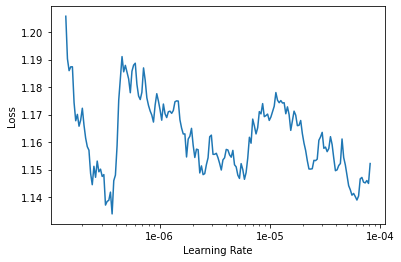

In [74]:
%%time
debug_train()

In [75]:
from functools import partial
import pysnooper

@pysnooper.snoop()
def train_loop(index, *args):
  #data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
  #        .random_split_by_pct(0.2)
  #        .label_from_df(cols=0)
  #        .transform(get_transforms(), size=224)
  #        .databunch(bs=32, num_workers=0)
  #        .normalize(imagenet_stat))
  #learn = cnn_learner(data, models.resnet152, metrics=accuracy).to_tpu_distributed()
    logger.debug("rank: %d entered train_loop", index)

    param_optimizer = list(k.model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'lr': 4e-5, 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'lr': 4e-5, 'weight_decay': 0.0}
    ]

    def AdamW_with_given_p(p_to_ignore, *args, **kargs):
        kargs['lr']=TrainGlobalConfig.lr*xm.xrt_world_size()

        return AdamW(optimizer_grouped_parameters, *args, **kargs)

    if index == 0:
        time.sleep(1)
    learn = k.create_learner(k, opt_func=AdamW_with_given_p,
                             loss_func=LabelSmoothing(),
                             wd=0.01,
                             callback_fns=[partial(GradientClipping, clip=0.5),
                                           ShowGraph,
                                           partial(CSVLogger, append=True),
                                           partial(CheckGrad, skip_loss_step=False)]
                             ).to_tpu_distributed()
    learn.lr_find(start_lr=1e-7, end_lr=1e-4, num_it=200)
    learn.recorder.plot()
    #learn.fit_one_cycle(3, max_lr=9e-6, wd=0.001)

In [76]:
FLAGS={}
#xmp.spawn(train_loop, args=(FLAGS,),  nprocs=8, start_method='fork')

Exception: ignored

In [ ]:
import pysnooper

@pysnooper.snoop()
def _mp_fn(rank, flags, k=k):
    device = xm.xla_device(devkind='TPU')
    logger.debug("%s used for xla_device" % device)
    net = k.model
    net.to(device)
    logger.debug("%s used for xla_device, to device done" % device)

    train_sampler = DistributedSamplerWrapper(
        sampler=BalanceClassSampler(labels=k.train_dataset.get_labels(), mode="downsampling"),
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    train_loader = torch.utils.data.DataLoader(
        k.train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=train_sampler,
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
    )
    validation_sampler = torch.utils.data.distributed.DistributedSampler(
        k.validation_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    validation_loader = torch.utils.data.DataLoader(
        k.validation_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=validation_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )
    validation_tune_sampler = torch.utils.data.distributed.DistributedSampler(
        k.validation_tune_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    validation_tune_loader = torch.utils.data.DataLoader(
        k.validation_tune_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=validation_tune_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )
    test_sampler = torch.utils.data.distributed.DistributedSampler(
        k.test_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        k.test_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=test_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )

    logger.debug("rank: %d", rank)

    if rank == 0:
        time.sleep(1)

    fitter = TPUFitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, validation_loader)
    fitter.run_tuning_and_inference(test_loader, validation_tune_loader)

In [ ]:
import gc
gc.collect()

626

In [ ]:
%%time

if __name__ == "__main__":
    FLAGS={}
    xmp.spawn(_mp_fn, args=(FLAGS,),  nprocs=8, start_method='fork')

[DEBUG]2020-06-18 13:58:51,269:utils:xla:1 used for xla_device
[DEBUG]2020-06-18 13:58:52,444:utils:xla:0 used for xla_device
[DEBUG]2020-06-18 13:58:52,728:utils:xla:0 used for xla_device
[DEBUG]2020-06-18 13:58:52,735:utils:xla:0 used for xla_device
[DEBUG]2020-06-18 13:58:52,853:utils:xla:0 used for xla_device
[DEBUG]2020-06-18 13:58:53,119:utils:xla:0 used for xla_device
[DEBUG]2020-06-18 13:58:53,616:utils:xla:0 used for xla_device
[DEBUG]2020-06-18 13:58:54,177:utils:xla:0 used for xla_device
[DEBUG]2020-06-18 13:59:59,523:utils:xla:1 used for xla_device, to device done
[DEBUG]2020-06-18 14:00:01,509:utils:xla:0 used for xla_device, to device done
[DEBUG]2020-06-18 14:00:06,897:utils:xla:0 used for xla_device, to device done
[DEBUG]2020-06-18 14:00:07,729:utils:xla:0 used for xla_device, to device done
[DEBUG]2020-06-18 14:00:08,287:utils:rank: 0
[DEBUG]2020-06-18 14:00:09,252:utils:xla:0 used for xla_device, to device done


Fitter prepared. Device is xla:1

2020-06-18T14:00:09.326978
LR: 4e-05


[DEBUG]2020-06-18 14:00:09,514:utils:xla:0 used for xla_device, to device done
[DEBUG]2020-06-18 14:00:09,514:utils:xla:0 used for xla_device, to device done
[DEBUG]2020-06-18 14:00:09,782:utils:xla:0 used for xla_device, to device done
[INFO]2020-06-18 14:00:10,024:utils:Train Step 0, loss: 0.00000, final_score: 0.00000, mc_score: 0.00000, time: 0.69253
[DEBUG]2020-06-18 14:00:10,570:utils:rank: 3
[INFO]2020-06-18 14:00:11,350:utils:Train Step 0, loss: 0.00000, final_score: 0.00000, mc_score: 0.00000, time: 0.74237
[INFO]2020-06-18 14:00:11,066:utils:step: 0, loss: 1.109375
[INFO]2020-06-18 14:00:12,402:utils:step: 0, loss: 1.132812
[DEBUG]2020-06-18 14:00:15,828:utils:rank: 1
[INFO]2020-06-18 14:00:16,519:utils:Train Step 0, loss: 0.00000, final_score: 0.00000, mc_score: 0.00000, time: 0.65324
[DEBUG]2020-06-18 14:00:16,559:utils:rank: 2
[INFO]2020-06-18 14:00:17,268:utils:Train Step 0, loss: 0.00000, final_score: 0.00000, mc_score: 0.00000, time: 0.67101
[DEBUG]2020-06-18 14:00:18,1

In [ ]:
from datetime import date
today = date.today()
output_model_file='XLMRobertaModel_tpu_trained.bin'
torch.save(k.model.state_dict(), f"{today}_{output_model_file}")

In [ ]:
submission = pd.concat([pd.read_csv(path) for path in glob('node_submissions/*.csv')]).groupby('id').mean()
submission['toxic'].hist(bins=100)

In [ ]:
submission.to_csv(f'{ROOT_PATH}/submission.csv')

#!cp log.txt '/content/drive/My Drive/jigsaw2020-kaggle-public-baseline/'
!make -C kaggle_runner push_dataset